# Test the sample and distributional accuracy of the GNN-based probabilistic models

In [1]:
import numpy as np
import torch
from torchvision import transforms
import numpy as np
import tqdm

import dgn4cfd as dgn 

In [2]:
device = torch.device('cuda:0')

Settings:

In [3]:
DATASET = dgn.datasets.DatasetUrl.pOnWingTrain
NUM_DENOISING_STEPS = 50
SIM_IDX = 3

Load the models:
- Diffusion Graph Net (DGN)
- Latent Diffusion Graph Net (LDGN)

In [4]:
# Diffusion Graph Net
DGN = dgn.nn.DiffusionGraphNet(
    checkpoint = "./checkpoints/dgn-nt250.chk",
    device     = device,
)

# Latent Diffusion Graph Net
LDGN = dgn.nn.LatentDiffusionGraphNet(
    autoencoder_checkpoint = "./checkpoints/ae-nt250.chk",
    checkpoint             = "./checkpoints/ldgn-nt250.chk",
    device                 = device,
)

# Flow Matching Graph Net
FMGN = dgn.nn.FlowMatchingGraphNet(
    checkpoint = "./checkpoints/fmgn-nt250.chk",
    device     = device,
)

Load a dataset

In [5]:
transform = transforms.Compose([
    dgn.transforms.ScaleEdgeAttr(0.015),
    dgn.transforms.EdgeCondFreeStream(normals='loc'),
    dgn.transforms.ScaleAttr('target', vmin=-1850,  vmax=400),
    dgn.transforms.MeshCoarsening(
        num_scales      =  6,
        rel_pos_scaling = [0.015, 0.03, 0.06, 0.12, 0.2, 0.4],
        scalar_rel_pos  = True, 
    ),
])
dataset = dgn.datasets.pOnWing(
    path       = dgn.datasets.DatasetDownloader(DATASET).file_path,
    T          = 250,
    transform  = transform,
    preload    = False,
)
print('Number of samples:', len(dataset))

T = 2500 # The grouth-truth trajectory length

Number of samples: 16


## Sample Inference
We sample from the distribution learned by each model, given the conditioning node and edge features. To compute the sample accuracy (coefficient of determination in this case), we find in the dataset the ground-truth sample closest to the predicted sample.

====== DGN ======
R2: 0.9810 at t=1044


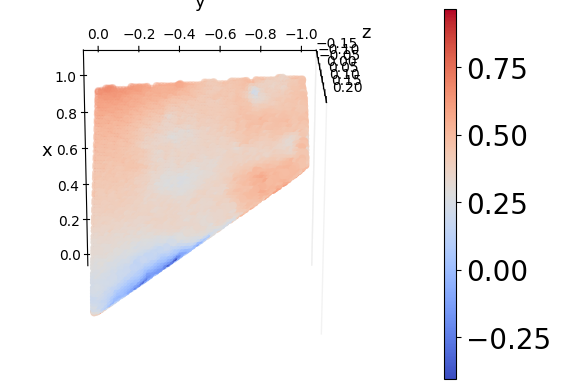

====== LDGN ======
R2: 0.9774 at t=2064


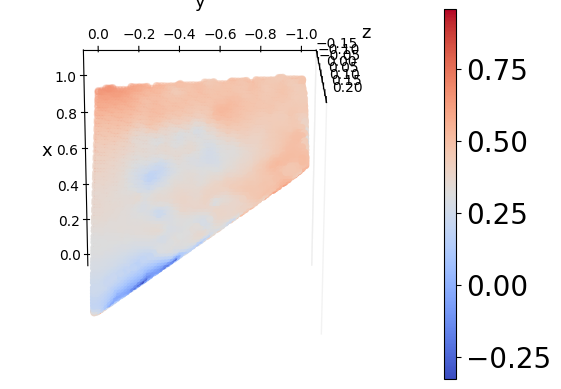

====== FMGN ======
R2: 0.9725 at t=1700


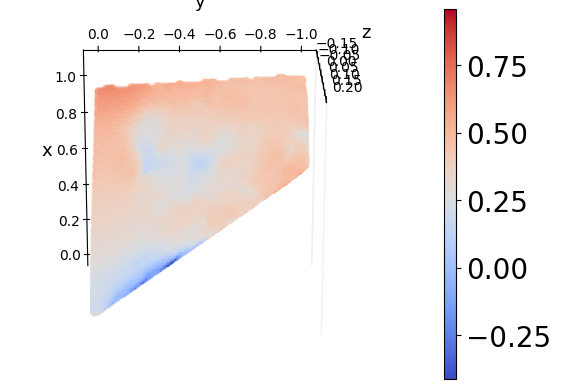

In [6]:
graph = dataset.get_sequence(SIM_IDX, n_in=T)


# DGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS) # Sample denoising steps for the DGN and LDGN
pred = DGN.sample(graph, steps=steps)

# Compute the accuracy
targets = graph.target.split(1, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t] # Ground-truth field closest to the prediction
print('====== DGN ======')
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
graph.plot_pos_field(pred[:,0], s=20, azim=180, elev=110)


# LDGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS) # Sample denoising steps for the DGN and LDGN
pred = LDGN.sample(graph, steps=steps)

# Compute the accuracy
targets = graph.target.split(1, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t] # Ground-truth field closest to the prediction
print('====== LDGN ======')
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
graph.plot_pos_field(pred[:,0], s=20, azim=180, elev=110)


# FMGN inference
steps = np.linspace(0, 1, NUM_DENOISING_STEPS + 1)
pred = FMGN.sample(graph, steps=steps)

# Compute the accuracy
targets = graph.target.split(1, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t] # Ground-truth field closest to the prediction
print('====== FMGN ======')
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
graph.plot_pos_field(pred[:,0], s=20, azim=180, elev=110)

## Distribution inference
We approximate the learned distributions by sampling many times. To quantify the distributional accuracy we compute the Wasserstein-2 distance considering the predicted distribution as a:
- 1D distribution at each node
- $|V|$-D distribution acrros the whole graph

====== DGN ======
R2 of mean: 0.9963 R2 of std: 0.8975
Wasserstein-2 distance 1d: 0.0114
Wasserstein-2 distance nd: 2.5746
	-Mean:


/home/lino/miniconda3/envs/dgn/lib/python3.12/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


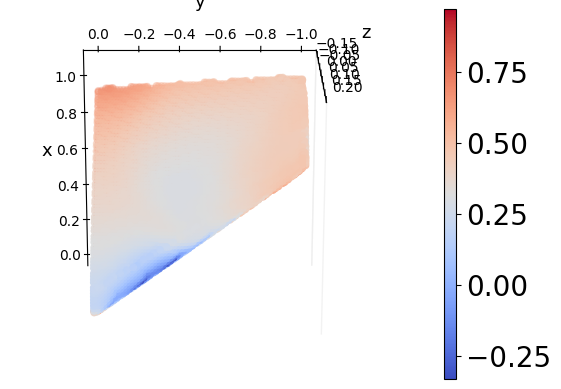

	-Std:


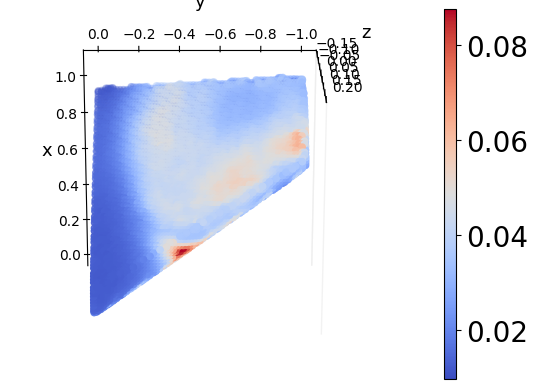

====== LDGN ======
R2 of mean: 0.9963 R2 of std: 0.9584
Wasserstein-2 distance 1d: 0.0119
Wasserstein-2 distance nd: 2.5150
	-Mean:


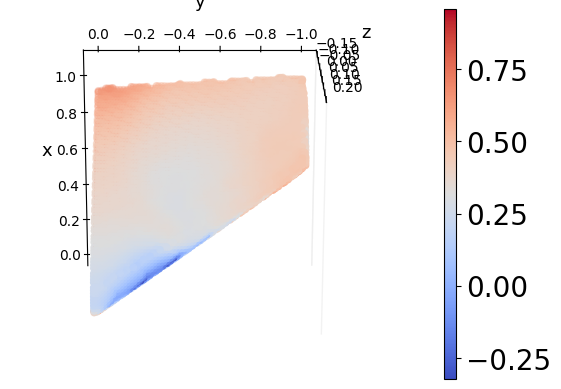

	-Std:


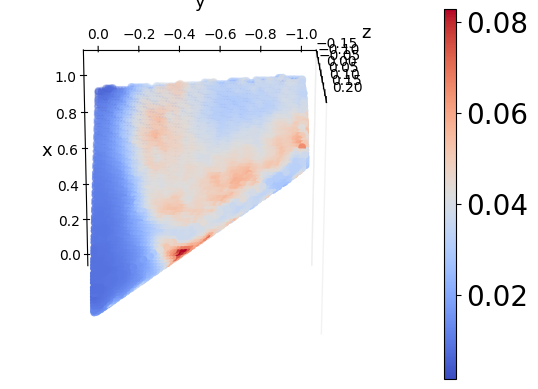

====== Flow-Matching GNN ======
R2 of mean: 0.9941 R2 of std: 0.9444
Wasserstein-2 distance 1d: 0.0114
Wasserstein-2 distance nd: 2.7316
	-Mean:


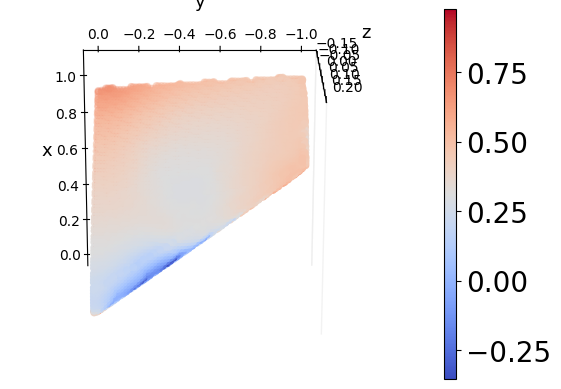

	-Std:


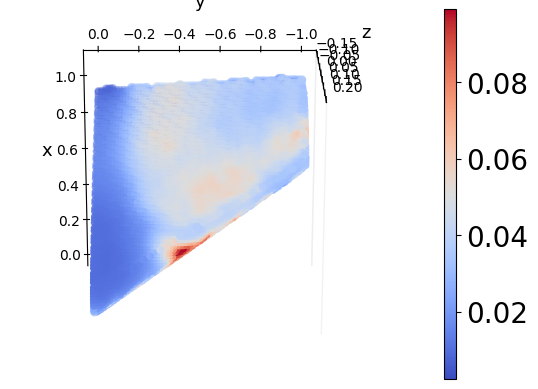

<vtkmodules.vtkCommonDataModel.vtkPolyData(0x2995fec0) at 0x7363cc0f6140>

In [7]:
NUM_SAMPLES = 3000
BATCH_SIZE  = 30 # Number of samples generated in parallel. Reduce this number if you run out of memory.


graph = dataset.get_sequence(SIM_IDX, n_in=T)
gt_mean = graph.target.mean(dim=1)
gt_std  = graph.target.std (dim=1)


# DGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = DGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== DGN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
print('\t-Mean:')
graph.plot_pos_field(mean, s=20, azim=180, elev=110)
print('\t-Std:')
graph.plot_pos_field(std , s=20, azim=180, elev=110)
# Save as vtk
# This creates a point cloud. To visualize it in Paraview, use the 'Point Gaussian' representation or create a mesh with the 'Delaunay 3D' filter
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = mean,
    filename  = 'dgn_mean.vtk',
    fieldname = 'mean',
)
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = std,
    filename  = 'dgn_std.vtk',
    fieldname = 'std',
)


# LDGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = LDGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== LDGN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
print('\t-Mean:')
graph.plot_pos_field(mean, s=20, azim=180, elev=110)
print('\t-Std:')
graph.plot_pos_field(std , s=20, azim=180, elev=110)
# Save as vtk
# This creates a point cloud. To visualize it in Paraview, use the 'Point Gaussian' representation or create a mesh with the 'Delaunay 3D' filter
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = mean,
    filename  = 'ldgn_mean.vtk',
    fieldname = 'mean',
)
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = std,
    filename  = 'ldgn_std.vtk',
    fieldname = 'std',
)


# Flow-Mathcing GNN inference
steps = np.linspace(0, 1, NUM_DENOISING_STEPS + 1)
pred = FMGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== Flow-Matching GNN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
print('\t-Mean:')
graph.plot_pos_field(mean, s=20, azim=180, elev=110)
print('\t-Std:')
graph.plot_pos_field(std , s=20, azim=180, elev=110)
# Save as vtk
# This creates a point cloud. To visualize it in Paraview, use the 'Point Gaussian' representation or create a mesh with the 'Delaunay 3D' filter
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = mean,
    filename  = 'fmgn_mean.vtk',
    fieldname = 'mean',
)
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = std,
    filename  = 'fmgn_std.vtk',
    fieldname = 'std',
)